# Experiment 3: LLava Approach -Clip Encoder/GPT2 Decoder

This experiment tests the LLava style projections using the HuggingFace Clip encoder and the gpt2 decoder. The experiment has two stages as outlined in the LLAva paper.

- **Stage One**: pretrains with the encoder and decoder frozen. The only trainable parameters at this stage are in the MLP used for image projections.

- **Stage Two**: performs fine-tuning with the decodr and MLP unfrozen. The pretrained MLP weights from stage one are loaded as the starting point for the MLP in stage two.

In [ ]:
import os
import sys
import torch
import torch.nn as nn
from transformers import AutoTokenizer
import datetime
import logging
import warnings
logging.getLogger("transformers").setLevel(logging.ERROR)
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
warnings.filterwarnings("ignore", category=UserWarning)

"""
Add support for either running in collab by uploading this notebook and
mounting the directory or locally from the room or experiments folder"
"""
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # NOTE: change the drive path if running with a mounted google drive in collab
    project_root = "/content/drive/Othercomputers/My MacBook Pro/image-captioning"
else:
    cwd = os.getcwd()

    if cwd.endswith("experiments"):
        project_root = os.path.abspath(os.path.join(cwd, '..'))
    else:
        project_root = cwd

if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

if IN_COLAB:
    !pip install evaluate > /dev/null 2>&1
    !pip install pycocoevalcap > /dev/null 2>&1


from vision_language_model import VisionLanguageModel
import train as train
import data_processing as dp
import download_data as get_data
import evaluation as eval


device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")

experiment = "experiment_3"
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Mounted at /content/drive
Project root: /content/drive/Othercomputers/My MacBook Pro/image-captioning


In [2]:
# download data, keep it outside of the mounted directory if running in collab to avoid data transfer overhead
if IN_COLAB:
    data_dir = "/content/flickr30k_data"
else:
    data_dir = os.path.join(project_root, "flickr30k_data")

# only download data if it does not already exist
if not os.path.exists(data_dir) or not os.listdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    get_data.download_and_partition(data_dir)
else:
    print(f"Data already exists in {data_dir}, skipping download.")

# setup saving directories
model_weights_dir = os.path.join(project_root, "model_weights")
evaluations_dir = os.path.join(project_root, "evaluations")
os.makedirs(model_weights_dir, exist_ok=True)
os.makedirs(evaluations_dir, exist_ok=True)

Download complete.
Extracting dataset...
Extraction complete.
Partitioning images...
Partitioning complete: 25426 training images, 3178 validation images, 3179 test images.
Partitioning captions...
Dataset preparation complete.


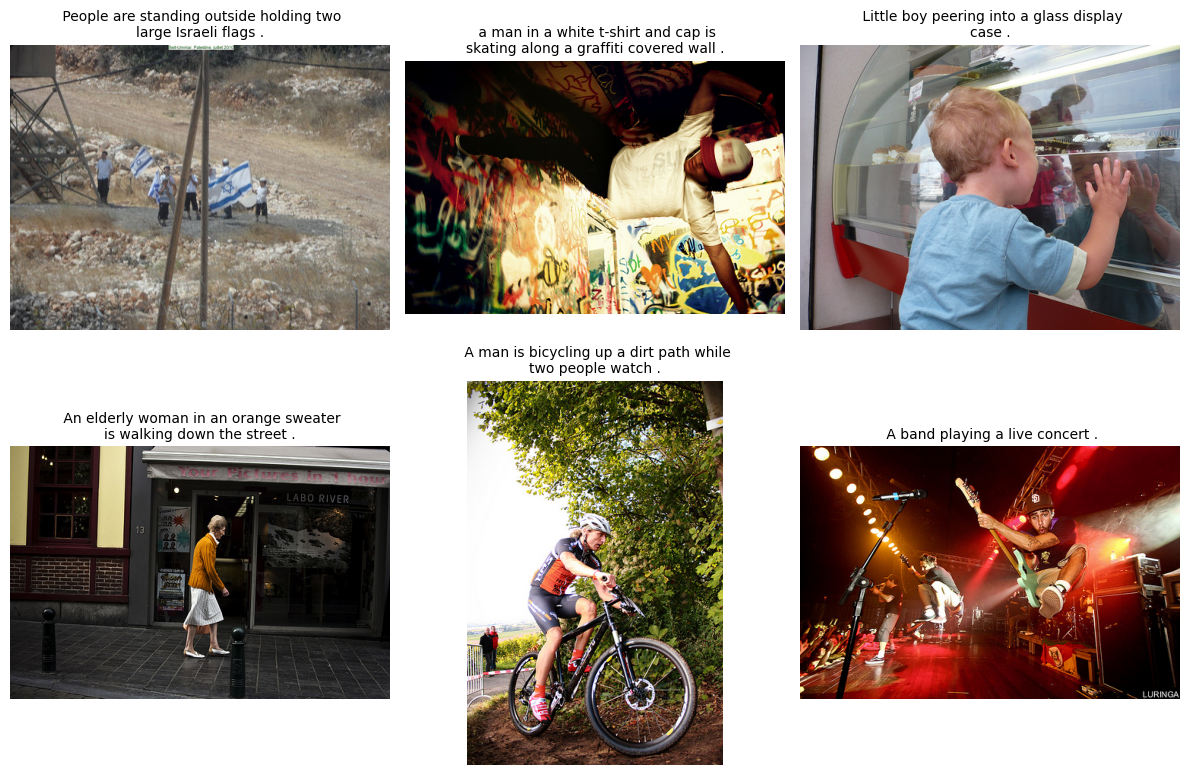

In [3]:
# load data
# Note: the train loader loads duplicate images with a 1:1 mapping of image to captions
# and the val/test loaders load images with a 1:N mapping of image to captions for evaluation
# these loaders will load batches of images rather than all images at once to avoid memory issues
train_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "train"), batch_size=4, eval_mode=False)
val_dir = os.path.join(data_dir, "val")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# visualize some training images
batch_1 = next(train_loader)
batch_2 = next(train_loader)
dp.visualize_random_captions([batch_1, batch_2])

## Stage One: Pretraining MLP

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# model config for stage one
model = VisionLanguageModel(
    image_encoder_type="clip",
    llava_projections=True,
    cross_attention=False,
    debug=False,
    decoder_type="gpt2",
    d_model=768,
    tokenizer=tokenizer
    ).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Initializing GPT-2 model...


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
%%time

max_batches=15000
num_epochs=1

train.train(
    model=model,
    train_dir=train_dir,
    val_dir=val_dir,
    loss_function=loss_fn,
    device=device,
    batch_size=4,
    num_epochs=num_epochs,
    training_type="mlp-pretrain",
    log_interval=1000,
    max_batches=max_batches,
    random_seed=1,
    lr_scheduler=True,
    learning_rate=2e-3,
    mlp_weights_path=os.path.join(model_weights_dir, f"{experiment}_pretrain_weights_{timestamp}.pt"),
    loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_pretrain_loss_{timestamp}.jpg"),
    )

Encoder and decoder weights frozen for LLava-style MLP pre-training.

Epoch 1/1
Step 1000: Loss = 3.9914
Step 2000: Loss = 3.4880
Step 3000: Loss = 3.3442
Step 4000: Loss = 3.2524
Step 5000: Loss = 3.1983
Step 6000: Loss = 3.1489
Step 7000: Loss = 3.1122
Step 8000: Loss = 3.0831
Step 9000: Loss = 3.0389
Step 10000: Loss = 3.0150
Step 11000: Loss = 3.0070
Step 12000: Loss = 2.9826
Step 13000: Loss = 2.9559
Step 14000: Loss = 2.9385
Step 15000: Loss = 2.9370
MLP weights saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/model_weights/experiment_3_pretrain_weights_2025-04-11_14-24-52.pt

Training complete.
CPU times: user 1h 2min 38s, sys: 18 s, total: 1h 2min 56s
Wall time: 1h 3min 47s


## Stage Two: Fine-tune

Fine-tuning full decoder and MLP.

Epoch 1/5
Step 1000: Loss = 3.1475
Step 2000: Loss = 2.9942
Step 3000: Loss = 2.9025
Step 4000: Loss = 2.8932
Step 5000: Loss = 2.8691

Epoch 2/5
Step 1000: Loss = 2.4915
Step 2000: Loss = 2.4144
Step 3000: Loss = 2.3515
Step 4000: Loss = 2.3452
Step 5000: Loss = 2.3359

Epoch 3/5
Step 1000: Loss = 2.0269
Step 2000: Loss = 1.9606
Step 3000: Loss = 1.9038
Step 4000: Loss = 1.8784
Step 5000: Loss = 1.8729


Sample Prediction: [' a man in a red hat is rowing a boat with a rope . He is pulling a fishing'], Reference: [' A man in waist deep water with a fishing net and wooden box in the river .', ' A man with a fishing net and gear stands waist-high in a body of water .', ' A man is waist deep in water with a fishing net and box .', ' A man is waist deep in a river casting a net .', ' Man in the water with a fishing net and box .']
Epoch 3 - BLEU: 0.1050, CIDEr: 0.2400

Epoch 4/5
Step 1000: Loss = 1.6020
Step 2000: Loss = 1.5516
Step 3000: Loss = 1.5031
Step 4000: Loss = 1.4656
Step 5000: Loss = 1.4718

Epoch 5/5
Step 1000: Loss = 1.2512
Step 2000: Loss = 1.2155
Step 3000: Loss = 1.1921
Step 4000: Loss = 1.1512
Step 5000: Loss = 1.1415

Plotting final evaluation metrics
Loss plot saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/evaluations/experiment_3_all_epochs_loss_2025-04-11_14-24-52.jpg


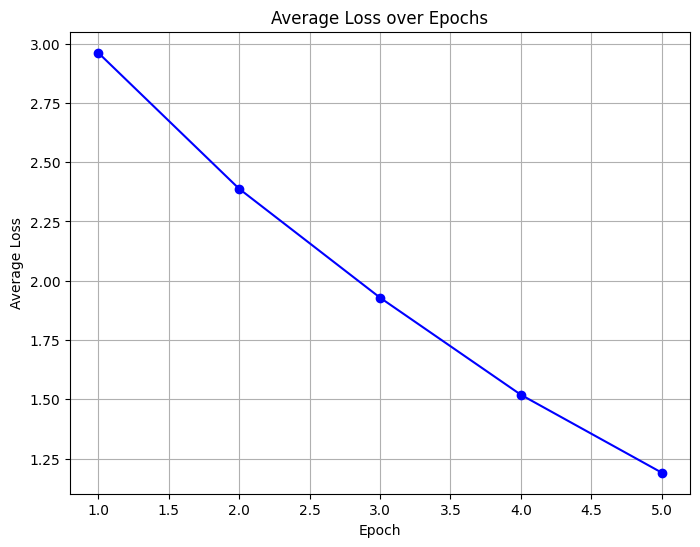

Decoder model saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/model_weights/experiment_3_finetune_weights_2025-04-11_14-24-52.pt

Training complete.
CPU times: user 2h 25min 55s, sys: 30.2 s, total: 2h 26min 26s
Wall time: 2h 27min 29s


In [ ]:
%%time
num_epochs=2
max_batches=3000

train.train(
    model=model,
    train_dir=train_dir,
    val_dir=val_dir,
    loss_function=loss_fn,
    device=device,
    batch_size=4,
    num_epochs=num_epochs,
    training_type="sft",
    max_batches=max_batches,
    log_interval=500,
    learning_rate=2e-4,
    random_seed=16,
    eval_every=2,
    model_weights_path=os.path.join(model_weights_dir, f"{experiment}_finetune_weights_{timestamp}.pt"),
    loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_finetune_loss_{timestamp}.jpg"),
    all_epochs_loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_all_epochs_loss_{timestamp}.jpg")
)

## Evaluate on Test Set

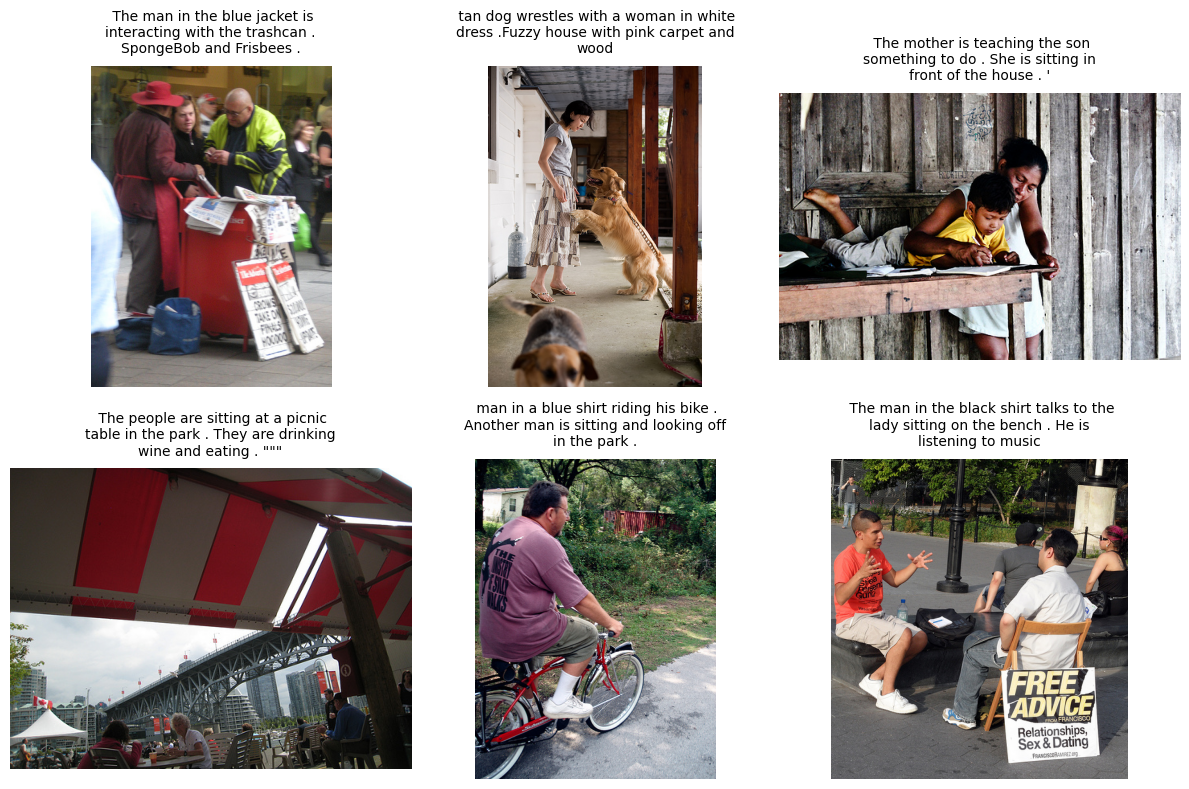

Sample Prediction: [' The man in the blue jacket is interacting with the trashcan . SpongeBob and Frisbees .'], Reference: [' A man in a bright green jacket is talking with two woman who are standing near something red that is covered in newspapers .', ' A man tries to sell people newspapers as they walk by .', ' A black man handing a woman cash for a paper .', ' Three people stand at a red cart .', ' A woman sells newspapers .']
BLEU: 0.0756, CIDEr: 0.1638


In [ ]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=4, eval_mode=True, seed=32)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=250,
    num_beams=2
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")

In [8]:
# save experiment results
results_path = os.path.join(evaluations_dir, "results.csv")

eval.save_experiment_results(experiment, cider, bleu, results_path)

Results saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/evaluations/results.csv
